In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf

In [2]:
df = pd.read_csv('../data/labels.csv')
df.head()

,Image_ID,Label,x,y,width,height
0,1478019952686311006_jpg.rf.907f842057bb95f7993...,7,0.433594,0.488333,0.016146,0.028333
1,1478019952686311006_jpg.rf.907f842057bb95f7993...,1,0.458594,0.494167,0.024479,0.026667
2,1478019952686311006_jpg.rf.907f842057bb95f7993...,1,0.508854,0.497500,0.028125,0.038333
3,1478019952686311006_jpg.rf.907f842057bb95f7993...,2,0.928646,0.510833,0.036458,0.218333
4,1478019953180167674_jpg.rf.9c29fc415228290603b...,7,0.394792,0.495833,0.017708,0.030000


### Feature Engineering

#### Transform bounding boxes from YOLO format to xmin, xmax, ymin, ymax format

In [11]:
def to_bounding_box(row):
    im = cv2.imread("../data/train/images/" + row['Image_ID'] +".jpg")
    if im is None:
        im = cv2.imread("../data/val/images/" + row['Image_ID'] +".jpg")
    if im is None:
        im = cv2.imread("../data/test/images/" + row['Image_ID'] +".jpg")
        
    h, w, c = im.shape
    x1, y1, w_size, h_size = row['x'], row['y'], row['width'], row['height'] 
    abs_x = x1 * w
    abs_y = y1 * h 
    abs_width = w_size * w 
    abs_height = h_size * h
    x_start = round(abs_x - (abs_width/2))
    y_start = round(abs_y - (abs_height/2))
    x_end = round(x_start + abs_width)
    y_end = round(y_start + abs_height)
    return x_start, y_start, x_end, y_end

In [12]:
new=[]
for i in range(len(df)):
    x_start, y_start, x_end, y_end = to_bounding_box(df.iloc[i])
    new.append([df.iloc[i]['Image_ID'], df.iloc[i]['Label'], int(x_start), int(y_start), int(x_end), (y_end)])

In [13]:
newdf = pd.DataFrame(data=new,columns=['Image_ID','Label','xmin','ymin','xmax','ymax'])

In [14]:
newdf

,Image_ID,Label,xmin,ymin,xmax,ymax
0,1478019952686311006_jpg.rf.907f842057bb95f7993...,7,218,243,226,258
1,1478019952686311006_jpg.rf.907f842057bb95f7993...,1,229,246,242,260
2,1478019952686311006_jpg.rf.907f842057bb95f7993...,1,253,245,267,265
3,1478019952686311006_jpg.rf.907f842057bb95f7993...,2,466,206,485,318
4,1478019953180167674_jpg.rf.9c29fc415228290603b...,7,198,246,207,261
...,...,...,...,...,...,...
97929,1478901536388465963_jpg.rf.a84d8640b19a1beb434...,1,279,236,359,320
97930,1478901536960505700_jpg.rf.e3e7089e7260c39c07b...,1,0,259,38,333
97931,1478901536960505700_jpg.rf.e3e7089e7260c39c07b...,1,39,258,66,296
97932,1478901536960505700_jpg.rf.e3e7089e7260c39c07b...,1,189,248,213,263


In [15]:
newdf.to_csv('labels-RCNN.csv', index=False)

### Create annotation files

#### Load labels

In [16]:
df=pd.read_csv('labels-RCNN.csv')
df.head()

,Image_ID,Label,xmin,ymin,xmax,ymax
0,1478019952686311006_jpg.rf.907f842057bb95f7993...,7,218,243,226,258
1,1478019952686311006_jpg.rf.907f842057bb95f7993...,1,229,246,242,260
2,1478019952686311006_jpg.rf.907f842057bb95f7993...,1,253,245,267,265
3,1478019952686311006_jpg.rf.907f842057bb95f7993...,2,466,206,485,318
4,1478019953180167674_jpg.rf.9c29fc415228290603b...,7,198,246,207,261


#### Plot bounding boxes

In [17]:
def plot_bbox(path, img_id):
    img_url = path + img_id + '.jpg'
    img = io.imread(img_url)
    height, width, channel = img.shape
    print(f"Image: {img.shape}")
    bboxs = df[df['Image_ID']==img_id]
    for index, row in bboxs.iterrows():
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        label_name = row['Label']
        print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(label_name), (xmin,ymin-10), font, 0.5, (0,255,0), 2)
    plt.figure(figsize=(15,10))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Image: (512, 512, 3)
Coordinates: (180, 250), (186, 258)
Coordinates: (198, 250), (202, 256)
Coordinates: (220, 250), (225, 256)
Coordinates: (215, 249), (221, 256)
Coordinates: (46, 237), (104, 291)
Coordinates: (118, 230), (147, 273)
Coordinates: (185, 247), (196, 264)
Coordinates: (383, 235), (408, 251)
Coordinates: (439, 228), (460, 254)
Coordinates: (458, 231), (477, 252)


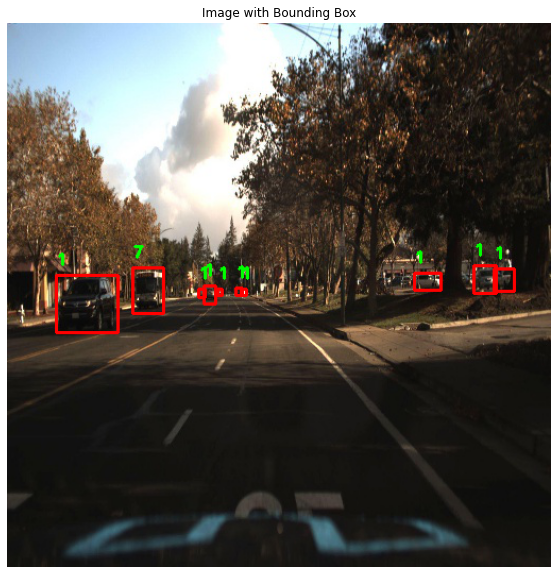

In [19]:
plot_bbox('../data/train/images/','1478019957687018435_jpg.rf.d41c6e88069ff4f754c02fa73b0b9d1b')

#### Get train, val, test images

In [20]:
# Train images
image_path = '../data/train/images/'
def load_images(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    images_files = sorted([os.path.join(path, i) for i in os.listdir(path) if i.endswith(".jpg")])
    return images_files

train_images = load_images(image_path)

In [21]:
# Validation images
image_path = '../data/val/images/'
val_images = load_images(image_path)

In [22]:
# Test images
image_path = '../data/test/images/'
test_images = load_images(image_path)

In [23]:
print(len(train_images), len(val_images), len(test_images))

9267 2648 1324


#### Create train annotation file

In [24]:
train_df = pd.DataFrame()
for img_id in train_images:
    partial = df[df['Image_ID']==img_id[21:-4]]
    train_df = pd.concat([train_df, partial])

In [25]:
with open("train_annotation.txt", "w+") as f:
    for idx, row in train_df.iterrows():
        img = cv2.imread('../data/train/images/' + row['Image_ID'] + ".jpg")
        x1 = row['xmin']
        x2 = row['xmax']
        y1 = row['ymin'] 
        y2 = row['ymax'] 
      
        fileName = '../../data/train/images/' + row['Image_ID'] + ".jpg"
        className = row['Label']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')

#### Create validation annotation file

In [26]:
val_df = pd.DataFrame()
for img_id in val_images:
    partial = df[df['Image_ID']==img_id[19:-4]]
    val_df = pd.concat([val_df, partial])

In [27]:
with open("val_annotation.txt", "w+") as f:
    for idx, row in val_df.iterrows():
        img = cv2.imread('../data/val/images/' + row['Image_ID'] + ".jpg")
        x1 = row['xmin']
        x2 = row['xmax']
        y1 = row['ymin'] 
        y2 = row['ymax'] 
      
        fileName = '../../data/val/images/' + row['Image_ID'] + ".jpg"
        className = row['Label']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')

#### Create test annotation file

In [28]:
test_df = pd.DataFrame()
for img_id in test_images:
    partial = df[df['Image_ID']==img_id[20:-4]]
    test_df = pd.concat([test_df, partial])

In [29]:
with open("test_annotation.txt", "w+") as f:
    for idx, row in test_df.iterrows():
        img = cv2.imread('../data/test/images/' + row['Image_ID'] + ".jpg")
        x1 = row['xmin']
        x2 = row['xmax']
        y1 = row['ymin'] 
        y2 = row['ymax'] 
      
        fileName = '../../data/test/images/' + row['Image_ID'] + ".jpg"
        className = row['Label']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')